In [24]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from safe.tokenizer import SAFETokenizer
from safe.trainer.model import SAFEDoubleHeadsModel
from rdkit import Chem
from rdkit.Chem import Draw, AllChem, rdFingerprintGenerator
from rdkit import rdBase
rdBase.DisableLog('rdApp.warning')
import os
from molfeat.trans.pretrained.hf_transformers import HFModel
import datamol as dm
import safe as sf
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import pickle
import hashlib
from PIL import Image
import cairosvg

In [25]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [26]:
# Load the trained model and tokenizer
model_checkpoint = "."
safe_model = SAFEDoubleHeadsModel.from_pretrained(model_checkpoint)

In [27]:
model_tokenizer = "./tokenizer.json"
safe_tokenizer = SAFETokenizer.from_pretrained(model_tokenizer)

In [28]:
# # Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
safe_model.to(device)

SAFEDoubleHeadsModel(
  (transformer): GPT2Model(
    (wte): Embedding(1880, 512)
    (wpe): Embedding(1024, 512)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=512, out_features=1880, bias=False)
  (multiple_choice_head): PropertyHead(
    (summary): Linear(in_features=512, out_features=128, bias=True)
 

In [29]:
def hash_smiles_list(smiles_list):
    """Create a hash of the SMILES list to use as a unique identifier."""
    return hashlib.md5(''.join(sorted(smiles_list)).encode()).hexdigest()

def save_processed_data(data, filename):
    """Save processed data to a file."""
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

def load_processed_data(filename):
    """Load processed data from a file."""
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [30]:
designer = sf.SAFEDesign(
    model=safe_model,
    tokenizer=safe_tokenizer,
    verbose=True,
)

In [31]:
generated_smiles = designer.de_novo_generation(sanitize=True, n_samples_per_trial=100, early_stopping=False, max_length=100)

  0%|          | 0/1 [00:00<?, ?it/s]

2024-08-04 17:41:53.987 | INFO     | safe.sample:de_novo_generation:592 - After sanitization, 99 / 100 (99.00 %) generated molecules are valid !


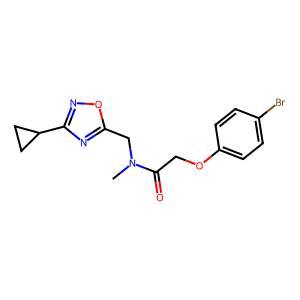

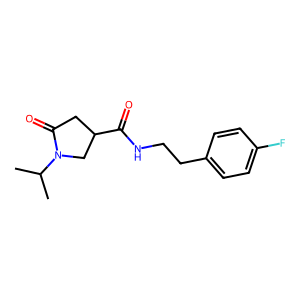

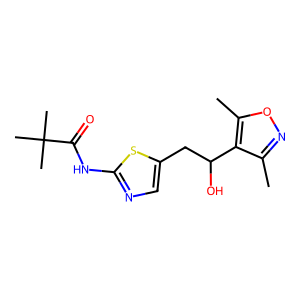

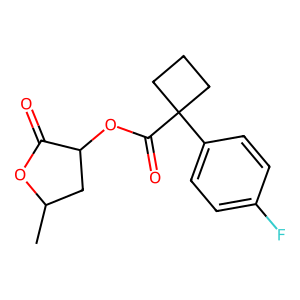

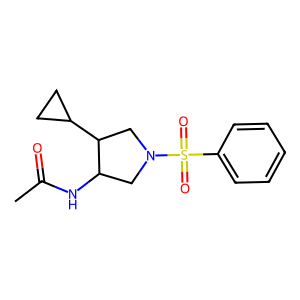

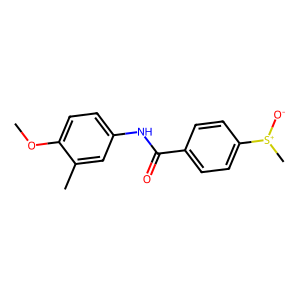

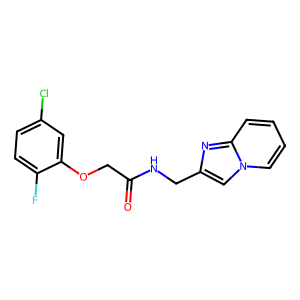

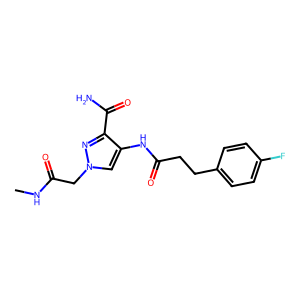

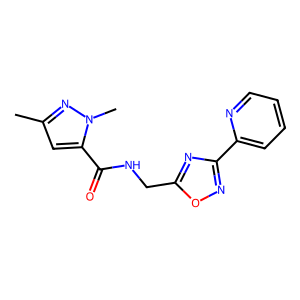

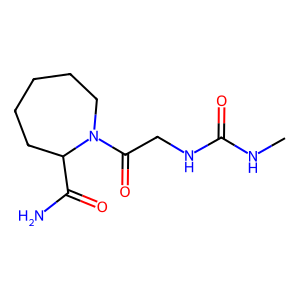

In [32]:
# Print first 10 generated molecules datamols
for i in range(10):
    display(dm.to_image(dm.to_mol(generated_smiles[i])))

In [33]:
mol_1 = dm.to_mol(generated_smiles[0])

img = dm.to_image(mol_1)
# Image.fromarray(img).save("mol_1.png")
img_path = "mol_1.png"
cairosvg.svg2png(bytestring=img.data, write_to=img_path)

In [34]:
# print max length of SMILES
max_len = max([len(s) for s in generated_smiles])
print(f"\nMax length of SMILES: {max_len}")

# average length of SMILES
avg_len = np.mean([len(s) for s in generated_smiles])
print(f"Average length of SMILES: {avg_len}")


Max length of SMILES: 50
Average length of SMILES: 37.23232323232323


In [35]:
# Save the generated SMILES
# with open("generated_smiles_10k.md", "w") as f:
#     for smiles in generated_smiles:
#         f.write(smiles + "\n")

In [36]:
# Load the generated SMILES
generated_smiles = []
with open("generated_smiles_10k.md", "r") as f:
    for line in f:
        generated_smiles.append(line.strip())

In [37]:
from rdkit.Chem import QED, Crippen
from rdkit import DataStructs
from rdkit.Chem import RDConfig
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
# now you can import sascore!
import sascorer

In [38]:
def process_molecules(smiles_list, desc):
    """Process SMILES strings into RDKit molecules."""
    mols = []
    for smi in tqdm(smiles_list, desc=desc, unit="molecule"):
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            mols.append(mol)
    return mols

def calculate_fingerprints(mols, radius=2, nBits=2048):
    """Calculate Morgan fingerprints for a list of molecules using MorganGenerator."""
    fingerprints = []
    morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, nBits=nBits)
    # morgan_gen = GetMorganGenerator(radius=radius, nBits=nBits)
    
    for mol in tqdm(mols, desc="Calculating fingerprints", unit="molecule"):
        fp = morgan_gen.GetFingerprint(mol)
        fingerprints.append(fp)
    
    return fingerprints

In [39]:
def calculate_diversity(fingerprints):
    print("Calculating pairwise diversities...")
    n = len(fingerprints)
    diversity = 0
    total_pairs = (n * (n - 1)) // 2
    
    with tqdm(total=total_pairs, desc="Calculating diversity", unit="pair") as pbar:
        for i in range(n):
            diversity += sum(1 - DataStructs.TanimotoSimilarity(fingerprints[i], fingerprints[j]) 
                             for j in range(i + 1, n))
            pbar.update(n - i - 1)
    
    return diversity / total_pairs if n > 1 else 0

In [40]:
# def calculate_novelty(gen_fps, ref_fps, similarity_threshold=0.9):
#     print("Calculating novelty...")
#     novel_count = 0
#     for gen_fp in tqdm(gen_fps, desc="Novelty calculation", unit="molecule"):
#         # Use BulkTanimotoSimilarity for efficient comparison
#         similarities = DataStructs.BulkTanimotoSimilarity(gen_fp, ref_fps)
#         if max(similarities) < similarity_threshold:
#             novel_count += 1
    
#     return novel_count / len(gen_fps) if gen_fps else 0

In [41]:
train_set = pd.read_csv("../../../train_from_scratch/Datasets/MOSES/train.csv")
test_set = pd.read_csv("../../../train_from_scratch/Datasets/MOSES/test.csv")
all_smiles = pd.concat([train_set, test_set])["SMILES"].unique()

moses_smiles = all_smiles.tolist()

In [42]:
# TODO: valid is not calculated correctly

def evaluate_generated_molecules(generated_smiles, reference_smiles):
    print("Starting molecule evaluation...")
    
    # Create hashes for the SMILES lists
    gen_hash = hash_smiles_list(generated_smiles)
    ref_hash = hash_smiles_list(reference_smiles)
    
    # Check if processed data exists
    gen_mol_file = f"gen_mols_{gen_hash}.pkl"
    # ref_mol_file = f"ref_mols_{ref_hash}.pkl"
    gen_fp_file = f"gen_fps_{gen_hash}.pkl"
    # ref_fp_file = f"ref_fps_{ref_hash}.pkl"
    
    # Process generated molecules
    if os.path.exists(gen_mol_file) and os.path.exists(gen_fp_file):
        print("Loading processed generated molecules and fingerprints...")
        valid_mols = load_processed_data(gen_mol_file)
        gen_fps = load_processed_data(gen_fp_file)
    else:
        print("Processing generated molecules...")
        valid_mols = process_molecules(generated_smiles, "Processing generated molecules")
        gen_fps = calculate_fingerprints(valid_mols)
        save_processed_data(valid_mols, gen_mol_file)
        save_processed_data(gen_fps, gen_fp_file)
    
    # Process reference molecules
    # if os.path.exists(ref_mol_file) and os.path.exists(ref_fp_file):
    #     print("Loading processed reference molecules and fingerprints...")
    #     reference_mols = load_processed_data(ref_mol_file)
    #     ref_fps = load_processed_data(ref_fp_file)
    # else:
    #     print("Processing reference molecules...")
    #     reference_mols = process_molecules(reference_smiles, "Processing reference molecules")
    #     ref_fps = calculate_fingerprints(reference_mols)
    #     save_processed_data(reference_mols, ref_mol_file)
    #     save_processed_data(ref_fps, ref_fp_file)
    
    # Calculate basic properties
    unique_smiles = set(Chem.MolToSmiles(mol) for mol in valid_mols)
    qed_scores = [QED.qed(mol) for mol in valid_mols]
    sas_scores = [sascorer.calculateScore(mol) for mol in valid_mols]
    
    validity = len(valid_mols) / len(generated_smiles) if generated_smiles else 0
    uniqueness = len(unique_smiles) / len(generated_smiles) if generated_smiles else 0
    
    print("Calculating diversity...")
    diversity = calculate_diversity(gen_fps)
    
    # print("Calculating novelty...")
    # novelty = calculate_novelty(gen_fps, ref_fps)
    
    qed_mean = sum(qed_scores) / len(qed_scores) if qed_scores else 0
    sas_mean = sum(sas_scores) / len(sas_scores) if sas_scores else 0
    
    return {
        "validity": validity,
        "uniqueness": uniqueness,
        "diversity": diversity,
        # "novelty": novelty,
        "qed_mean": qed_mean,
        "sas_mean": sas_mean,
    }

In [43]:
evaluation_results = evaluate_generated_molecules(generated_smiles, moses_smiles)

Starting molecule evaluation...
Loading processed generated molecules and fingerprints...
Calculating diversity...
Calculating pairwise diversities...


Calculating diversity: 100%|██████████| 49536081/49536081 [01:48<00:00, 454537.20pair/s]


In [23]:
print(f"Validity of paper is 1, computed is {evaluation_results['validity']:.3f}")
print(f"Uniqueness of paper is 0.999, computed is {evaluation_results['uniqueness']:.3f}")
print(f"Diversity of paper is 0.864, computed is {evaluation_results['diversity']:.3f}")
# print(f"Novelty: {evaluation_results['novelty']:.3f}")
print(f"QED mean is {evaluation_results['qed_mean']:.3f}")
print(f"SAS mean is {evaluation_results['sas_mean']:.3f}")

Validity of paper is 1, computed is 1.000
Uniqueness of paper is 0.999, computed is 0.999
Diversity of paper is 0.864, computed is 0.865
QED mean is 0.804
SAS mean is 2.489


In [20]:
with open("safe_small_results.md", "w") as f:
    f.write(f"Validity of paper is 1, computed is {evaluation_results['validity']:.3f}\n")
    f.write(f"Uniqueness of paper is 0.999, computed is {evaluation_results['uniqueness']:.3f}\n")
    f.write(f"Diversity of paper is 0.864, computed is {evaluation_results['diversity']:.3f}\n")
    f.write(f"Novelty: {evaluation_results['novelty']:.3f}\n")
    f.write(f"QED mean is {evaluation_results['qed_mean']:.3f}\n")
    f.write(f"SAS mean is {evaluation_results['sas_mean']:.3f}\n")

More nuanced evaluation

In [21]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors, Lipinski
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
def smiles_to_mol(smiles_list):
    return [Chem.MolFromSmiles(smi) for smi in smiles_list if Chem.MolFromSmiles(smi) is not None]

In [23]:
generated_mols = smiles_to_mol(generated_smiles)
moses_mols = smiles_to_mol(moses_smiles)

In [24]:
def calculate_properties(mol_list):
    properties = {
        'MW': [], 'LogP': [], 'HBD': [], 'HBA': [], 'TPSA': [], 'RotBonds': [], 'QED': []
    }
    for mol in mol_list:
        properties['MW'].append(Descriptors.ExactMolWt(mol))
        properties['LogP'].append(Crippen.MolLogP(mol))
        properties['HBD'].append(Lipinski.NumHDonors(mol))
        properties['HBA'].append(Lipinski.NumHAcceptors(mol))
        properties['TPSA'].append(Descriptors.TPSA(mol))
        properties['RotBonds'].append(rdMolDescriptors.CalcNumRotatableBonds(mol))
        properties['QED'].append(Descriptors.qed(mol))
    return properties

In [25]:
generated_properties = calculate_properties(generated_mols)
moses_properties = calculate_properties(moses_mols)

In [58]:
def plot_property_distributions(gen_props, ref_props, property_name, xlabel, ylabel="Density", plot_type='line'):
    plt.figure(figsize=(10, 6))
    
    if plot_type == 'line':
        sns.kdeplot(gen_props, label='Generated', color='blue', fill=True)
        sns.kdeplot(ref_props, label='MOSES', color='red', fill=True)
    elif plot_type == 'bar':
        gen_counts, gen_bins = np.histogram(gen_props, bins=range(min(min(gen_props), min(ref_props)), max(max(gen_props), max(ref_props)) + 2))
        ref_counts, ref_bins = np.histogram(ref_props, bins=gen_bins)
        
        gen_counts = gen_counts / len(gen_props)
        ref_counts = ref_counts / len(ref_props)
        
        width = 0.35
        plt.bar(gen_bins[:-1], gen_counts, width, label='Generated', alpha=0.7, color='blue')
        plt.bar(ref_bins[:-1] + width, ref_counts, width, label='MOSES', alpha=0.7, color='red')
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f'Distribution of {property_name}')
    plt.legend()
    plt.savefig(f'{property_name.lower().replace(" ", "_")}_distribution.png')
    plt.close()

In [59]:
def plot_property_boxplots(gen_props, ref_props):
    plt.figure(figsize=(15, 10))
    
    data = []
    for prop, name, _, _ in properties_to_plot:
        for value in gen_props[prop]:
            data.append({
                'Property': name,
                'Value': value,
                'Dataset': 'Generated'
            })
        for value in ref_props[prop]:
            data.append({
                'Property': name,
                'Value': value,
                'Dataset': 'MOSES'
            })
    
    df = pd.DataFrame(data)
    
    sns.boxplot(x='Property', y='Value', hue='Dataset', data=df)
    plt.xticks(rotation=45, ha='right')
    plt.title('Box Plots of Molecular Properties')
    plt.tight_layout()
    plt.savefig('molecular_properties_boxplots.png')
    plt.close()

In [60]:
def plot_individual_boxplots(gen_props, ref_props):
    for prop, name, _, _ in properties_to_plot:
        plt.figure(figsize=(10, 6))
        data = [
            {'Property': name, 'Value': value, 'Dataset': 'Generated'} for value in gen_props[prop]
        ] + [
            {'Property': name, 'Value': value, 'Dataset': 'MOSES'} for value in ref_props[prop]
        ]
        df = pd.DataFrame(data)
        
        sns.boxplot(x='Dataset', y='Value', data=df)
        plt.title(f'Box Plot of {name}')
        plt.ylabel(name)
        plt.tight_layout()
        plt.savefig(f'{name.lower().replace(" ", "_")}_boxplot.png')
        plt.close()

In [61]:
properties_to_plot = [
    ('MW', 'Molecular Weight', 'Molecular Weight (Da)', 'line'),
    ('LogP', 'LogP', 'LogP', 'line'),
    ('HBD', 'H-Bond Donors', 'Number of H-Bond Donors', 'bar'),
    ('HBA', 'H-Bond Acceptors', 'Number of H-Bond Acceptors', 'bar'),
    ('TPSA', 'Topological Polar Surface Area', 'TPSA (Å²)', 'line'),
    ('RotBonds', 'Rotatable Bonds', 'Number of Rotatable Bonds', 'bar'),
    ('QED', 'QED', 'Quantitative Estimate of Drug-likeness', 'line')
]

for prop, name, xlabel, plot_type in properties_to_plot:
    plot_property_distributions(generated_properties[prop], moses_properties[prop], name, xlabel, plot_type=plot_type)

In [47]:
plot_property_boxplots(generated_properties, moses_properties)

In [49]:
plot_individual_boxplots(generated_properties, moses_properties)

In [50]:
from tabulate import tabulate

def print_summary_stats(gen_props, ref_props):
    headers = ["Property", "Generated (mean ± std)", "MOSES (mean ± std)"]
    table_rows = []
    
    for prop, name, _, _ in properties_to_plot:
        gen_mean, gen_std = np.mean(gen_props[prop]), np.std(gen_props[prop])
        ref_mean, ref_std = np.mean(ref_props[prop]), np.std(ref_props[prop])
        row = [name, f"{gen_mean:.2f} ± {gen_std:.2f}", f"{ref_mean:.2f} ± {ref_std:.2f}"]
        table_rows.append(row)
    
    print(tabulate(table_rows, headers=headers, tablefmt="grid"))

In [51]:
print_summary_stats(generated_properties, moses_properties)

+--------------------------------+--------------------------+----------------------+
| Property                       | Generated (mean ± std)   | MOSES (mean ± std)   |
+================================+==========================+======================+
| Molecular Weight               | 310.17 ± 28.97           | 306.92 ± 28.00       |
+--------------------------------+--------------------------+----------------------+
| LogP                           | 2.46 ± 0.96              | 2.44 ± 0.93          |
+--------------------------------+--------------------------+----------------------+
| H-Bond Donors                  | 1.12 ± 0.84              | 1.12 ± 0.83          |
+--------------------------------+--------------------------+----------------------+
| H-Bond Acceptors               | 4.34 ± 1.44              | 4.22 ± 1.40          |
+--------------------------------+--------------------------+----------------------+
| Topological Polar Surface Area | 67.04 ± 18.39            | 65.

scaffold analysis

In [52]:
from rdkit.Chem.Scaffolds import MurckoScaffold

In [53]:
def analyze_scaffolds(mol_list):
    scaffolds = {}
    for mol in mol_list:
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        scaffold_smiles = Chem.MolToSmiles(scaffold)
        scaffolds[scaffold_smiles] = scaffolds.get(scaffold_smiles, 0) + 1
    return scaffolds

In [54]:
generated_scaffolds = analyze_scaffolds(generated_mols)
moses_scaffolds = analyze_scaffolds(moses_mols)

In [55]:
print(f"Unique scaffolds in generated set: {len(generated_scaffolds)}")
print(f"Unique scaffolds in MOSES set: {len(moses_scaffolds)}")

Unique scaffolds in generated set: 7272
Unique scaffolds in MOSES set: 404141


In [56]:
# Scaffold diversity
gen_scaffold_diversity = len(generated_scaffolds) / len(generated_mols)
moses_scaffold_diversity = len(moses_scaffolds) / len(moses_mols)

print(f"Scaffold diversity in generated set: {gen_scaffold_diversity:.4f}")
print(f"Scaffold diversity in MOSES set: {moses_scaffold_diversity:.4f}")

Scaffold diversity in generated set: 0.7306
Scaffold diversity in MOSES set: 0.2295
